In [212]:
import os 
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
import tensorflow as tf 
import tensorflow.keras as tfk 
import tensorflow.keras.layers as tfkl 
plt.rc('font', size=16) 
import random
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn import model_selection
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight
from sklearn.preprocessing import MinMaxScaler
import warnings
import logging
from sklearn import preprocessing 


tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.6.4


In [213]:
# Random seed for reproducibility
seed = 89
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [214]:
path = r'/kaggle/input/dataset-hw2-ann/'
x_train = np.load(path + r'x_train.npy')
y_train = np.load(path + r'y_train.npy')

# Dataset visualization

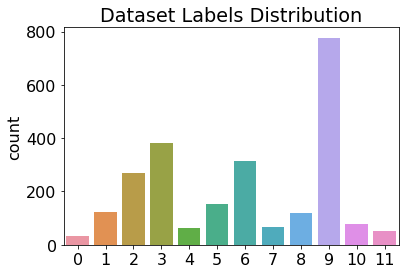

In [215]:
# plot labels distribution 
sns.countplot( x = y_train) 
plt.title('Dataset Labels Distribution')
plt.show()

In [216]:
# setting up 
labels = np.unique(np.fromiter([i for i in y_train], np.int32) )
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=labels, y=y_train) 

In [217]:
    from scipy.interpolate import interp1d
    x_new = [] 
    for el in x_train: 
        interp = interp1d(x=np.arange(36), y=el, axis=0, kind='cubic')
        el = interp(np.arange(0, 35, .2))
        x_new.append(el)
    x_new = np.array(x_new) 
    print(x_new.shape) 
    x_train = x_new

(2429, 175, 6)


In [218]:
# split 
x_train, x_test, y_train, y_test = model_selection.train_test_split(x_train, y_train, test_size=0.2, random_state=seed, stratify=y_train) 
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape )

(1943, 175, 6) (1943,) (486, 175, 6) (486,)


In [219]:
y_train = tfk.utils.to_categorical(y_train) 
y_test = tfk.utils.to_categorical(y_test)

In [220]:
train_data = np.concatenate([x for x in x_train]) 
print(train_data.shape) 
scaler = preprocessing.RobustScaler().fit(train_data) #robust scaler best to time, outliers? 

x_train_trans = [] 
for el in x_train: 
    x_train_trans.append(scaler.transform(el))
del x_train 

x_test_trans = [] 
for el in x_test :
    x_test_trans.append(scaler.transform(el))

x_train = np.asarray(x_train_trans) 
x_test = np.asarray(x_test_trans)

(340025, 6)


In [221]:
print(x_train.shape, y_train.shape)

(1943, 175, 6) (1943, 12)


Resampling

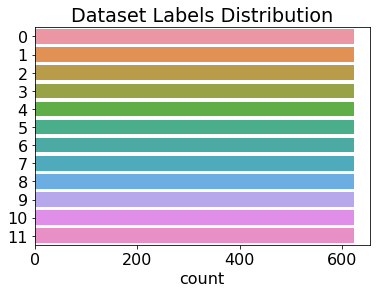

(7464, 1050) (7464, 12)
(7464, 175, 6) (7464, 12)


In [222]:
OLD_SHAPE = x_train.shape[1]
x_train_reshaped = tf.reshape(x_train, shape = (x_train.shape[0], x_train.shape[1]*6) )
#print(x_train_reshaped.shape, y_train.shape)  
from imblearn.over_sampling import RandomOverSampler, SVMSMOTE, SMOTE
from imblearn.combine import SMOTEENN

ros = RandomOverSampler(sampling_strategy='not majority' ,random_state=seed)
train_data, labels = ros.fit_resample(x_train_reshaped, y_train)

plotting_labels = np.argmax(labels, axis = 1)
sns.countplot( y = plotting_labels) 
plt.title('Dataset Labels Distribution')
plt.show()

print(train_data.shape, labels.shape) 
x_res = tf.reshape(train_data, shape = (train_data.shape[0], OLD_SHAPE, 6) ) #PUT NEW SIZE HERE 
y_res = labels #from above 
print(x_res.shape, y_res.shape)

In [223]:
X = x_res 
Y = y_res

print(X.shape, Y.shape) 
input_shape = (OLD_SHAPE,6)

(7464, 175, 6) (7464, 12)


In [224]:
! pip install tsaug > /dev/null ; 

In [225]:
from tsaug import TimeWarp, Crop, Quantize, Drift, Reverse, AddNoise
my_augmenter = (
     TimeWarp() # random warping in parallel 
     + Drift(max_drift=(0.1, 0.6)) @ 0.3  # with 80% probability, random drift the signal up to 10% - 50%
     + Reverse() @ 0.2 # with 50% probability, reverse the sequence
)

In [226]:
print(X.shape, Y.shape )
X = np.array(X) 
X_aug = my_augmenter.augment(X) 

(7464, 175, 6) (7464, 12)


In [227]:
X = np.concatenate((X, X_aug)) #real data + augmented ones 
Y = np.concatenate((Y, Y))

In [228]:
from sklearn.utils import shuffle 
X, Y = shuffle(X, Y)

# Network

In [229]:
def build_ffnn_classifier(input_shape, classes):
    input_layer = tfkl.Input(shape=input_shape, name='Input')
    x = input_layer
    x = tfkl.GaussianNoise(stddev=0.001)(x) 
    cnn_1 = tfkl.Conv1D(256,3,padding='same',activation='relu')(x) 
    cnn = tfkl.MaxPooling1D()(cnn_1)
    cnn = tfkl.Conv1D(256,3,padding='same',activation='relu')(cnn)
    cnn = tfkl.MaxPooling1D()(cnn)
    cnn = tfkl.Conv1D(256,3,padding='same',activation='relu')(cnn)
    x = tfkl.MultiHeadAttention( key_dim=6, num_heads=5, dropout=0.5)(cnn,tfkl.MaxPool1D(strides = 2)(input_layer)) 
    x = tfkl.Add()([cnn, tfkl.MaxPool1D(strides = 4)(cnn_1)[:, :-1, :]  ])
    
    norm = tfkl.BatchNormalization()(x)
    
    cnn_1 = tfkl.Conv1D(256,3,padding='same',activation='relu')(norm) 
    cnn = tfkl.MaxPooling1D()(cnn_1)
    cnn = tfkl.Conv1D(256,3,padding='same',activation='relu')(cnn)
    cnn = tfkl.MaxPooling1D()(cnn)
    cnn = tfkl.Conv1D(256,3,padding='same',activation='relu')(cnn)
    
    x = tfkl.MultiHeadAttention( key_dim=6, num_heads=5, dropout=0.5)(cnn,tfkl.MaxPool1D(strides = 2)(cnn) ) 
    x = tfkl.Add()([cnn, tfkl.MaxPool1D(strides = 4)(cnn_1)[:, :-1, :]  ])
    norm = tfkl.BatchNormalization()(x)
    
    gap = tfkl.GlobalAveragePooling1D()(norm)
    dropout = tfkl.Dropout(.3, seed=seed)(gap)

    hidden_layer1 = tfkl.Dense(units=256, activation ='relu', name = 'Hidden1', kernel_regularizer = tfk.regularizers.L2(l2 = 0.003))(dropout) 
    dropout = tfkl.Dropout(.3, seed=seed)(hidden_layer1)
    hidden_layer2 = tfkl.Dense(units=256, activation ='relu', name = 'Hidden2', kernel_regularizer = tfk.regularizers.L2(l2 = 0.003))(dropout) 
    
    output_layer = tfkl.Dense(classes, activation='softmax', 
                              #kernel_regularizer = tfk.regularizers.L2(l2 = 0.01),
                              kernel_initializer=tfk.initializers.GlorotUniform(seed))(hidden_layer2)
      
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')
    return model

In [230]:
model = build_ffnn_classifier(input_shape, 12)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 175, 6)]     0                                            
__________________________________________________________________________________________________
gaussian_noise_2 (GaussianNoise (None, 175, 6)       0           Input[0][0]                      
__________________________________________________________________________________________________
conv1d_48 (Conv1D)              (None, 175, 256)     4864        gaussian_noise_2[0][0]           
__________________________________________________________________________________________________
max_pooling1d_64 (MaxPooling1D) (None, 87, 256)      0           conv1d_48[0][0]                  
______________________________________________________________________________________________

In [231]:
class_weights 
weights = dict(zip([i for i in range(12)],class_weights)) 

In [232]:
history1 = model.fit(
    x = X,
    y = Y,
    batch_size = 64,
    epochs = 300,
    validation_data = (x_test, y_test),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=40, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=30, factor=0.2, min_lr=1e-5)
    ]
).history

Epoch 1/300
234/234 [==============================] - 4s 13ms/step - loss: 2.9017 - accuracy: 0.3426 - val_loss: 2.5755 - val_accuracy: 0.2325
Epoch 2/300
234/234 [==============================] - 3s 11ms/step - loss: 1.9739 - accuracy: 0.4719 - val_loss: 2.2546 - val_accuracy: 0.2490
Epoch 3/300
234/234 [==============================] - 3s 11ms/step - loss: 1.5297 - accuracy: 0.5447 - val_loss: 2.1349 - val_accuracy: 0.2284
Epoch 4/300
234/234 [==============================] - 3s 12ms/step - loss: 1.3269 - accuracy: 0.5907 - val_loss: 1.7732 - val_accuracy: 0.3621
Epoch 5/300
234/234 [==============================] - 3s 11ms/step - loss: 1.1617 - accuracy: 0.6316 - val_loss: 1.8212 - val_accuracy: 0.4053
Epoch 6/300
234/234 [==============================] - 3s 11ms/step - loss: 1.0219 - accuracy: 0.6764 - val_loss: 1.5959 - val_accuracy: 0.3704
Epoch 7/300
234/234 [==============================] - 3s 12ms/step - loss: 0.9192 - accuracy: 0.7128 - val_loss: 1.4618 - val_accuracy:

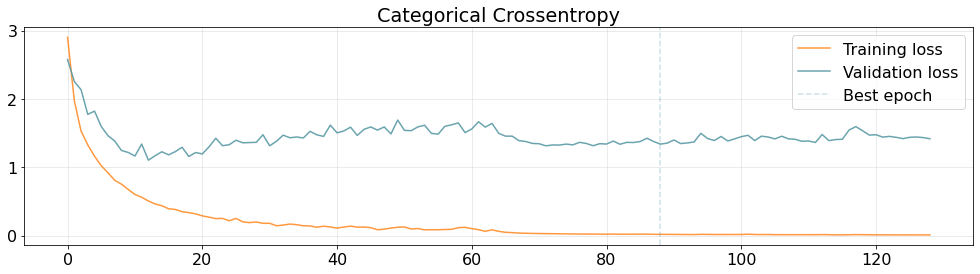

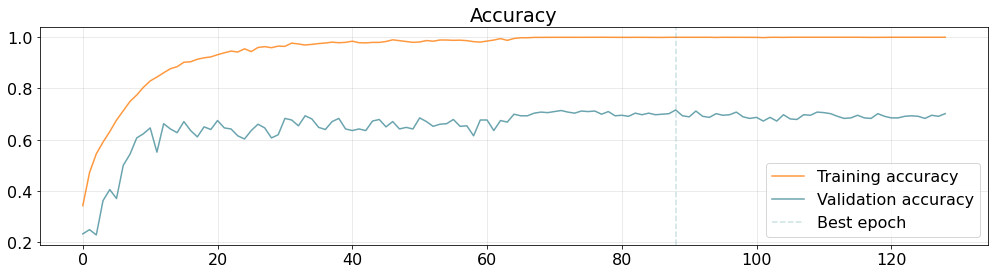

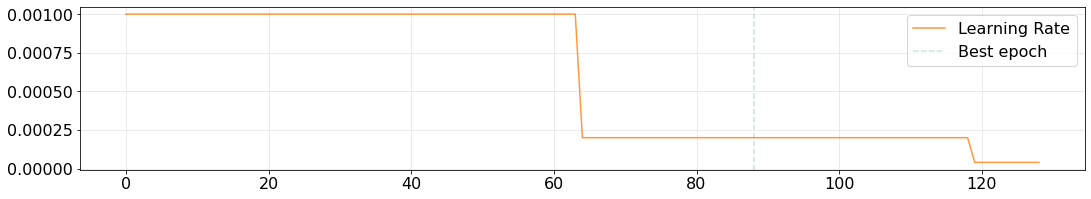

In [233]:
best_epoch = np.argmax(history1['val_accuracy'])
plt.figure(figsize=(17,4))
plt.plot(history1['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history1['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Categorical Crossentropy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history1['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history1['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history1['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

16/16 [==============================] - 0s 2ms/step - loss: 0.0145 - accuracy: 0.0000e+00
{'loss': 0.014512927271425724, 'accuracy': 0.0}
Accuracy: 0.716
Precision: 0.6782
Recall: 0.6137
F1: 0.6355
F1 (per class): [0.72727273 0.69387755 0.92727273 0.51315789 0.31578947 0.33333333
 0.87022901 0.24       0.91304348 0.7673716  0.90322581 0.42105263]


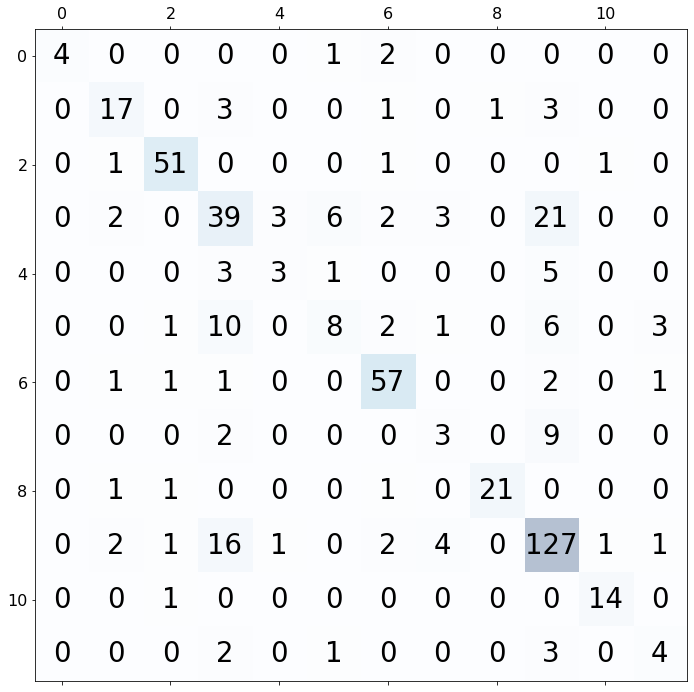

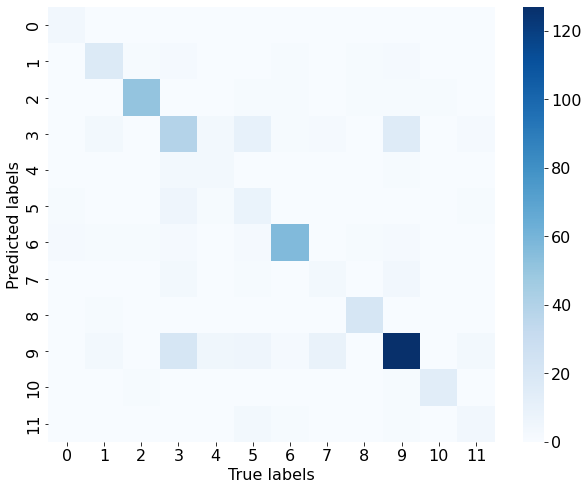

In [234]:
metrics = model.evaluate(x_test, return_dict=True)
print(metrics)

labels = y_test 
predictions = model.predict(x_test) 
assert len(labels) == len(predictions)

# Compute the confusion matrix
cm = confusion_matrix(np.argmax(labels, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(labels, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(labels, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(labels, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(labels, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1_classes = f1_score(np.argmax(labels, axis=-1), np.argmax(predictions, axis=-1), average=None)

print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))
print('F1 (per class):' ,f1_classes)

# Plot the confusion matrix
ig, ax = plt.subplots(figsize=(12,12))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i,s=cm[i, j], va='center', ha='center', size='xx-large')

        
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

In [235]:
model.save('sub')

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [236]:
import pickle 
with open(r'scaler', 'wb') as f: 
    pickle.dump(scaler, f)